In [ ]:
import pandas as pd
import numpy as np
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

from src.config import PROCESSED_DATA_DIR

# ======== 1. Đọc dữ liệu và chuẩn hóa ngành hàng ========
assoc_rules = pd.read_csv(f"{PROCESSED_DATA_DIR}/association_rules.csv")
freq_itemsets = pd.read_csv(f"{PROCESSED_DATA_DIR}/frequent_itemsets.csv")
# Nếu có file high utility itemsets thì mở ra luôn
hui_results = pd.read_csv(f"{PROCESSED_DATA_DIR}/hui_results.csv")


def extract_all_items(*series):
    items = []
    for ser in series:
        items += [item for sublist in ser.apply(eval) for item in sublist]
    return items


ants = assoc_rules["antecedent"].apply(eval)
cons = assoc_rules["consequent"].apply(eval)
all_items_assoc = [
    item for sublist in ants.tolist() + cons.tolist() for item in sublist
]
all_items_freq = extract_all_items(freq_itemsets["items"])
all_items_hui = extract_all_items(hui_results["items"])  # Nếu dùng thêm high utility
all_categories = sorted(
    set(all_items_assoc + all_items_freq)
)  # + all_items_hui nếu muốn

N = len(all_categories)

# ======== 2. Tạo affinity matrix (lift) ========
affinity = pd.DataFrame(0.0, index=all_categories, columns=all_categories, dtype=float)
for _, row in assoc_rules.iterrows():
    ants = eval(row["antecedent"])
    cons = eval(row["consequent"])
    lift = row["lift"]
    for a in ants:
        for c in cons:
            if a in affinity.index and c in affinity.columns:
                affinity.loc[a, c] = max(affinity.loc[a, c], lift)
                affinity.loc[c, a] = max(affinity.loc[c, a], lift)

# ======== 3. TỰ ĐỘNG LỌC FORBIDDEN PAIRS (chỉ cặp lift == 0) ========
forbidden_pairs = set()
for i in range(len(all_categories)):
    for j in range(i + 1, len(all_categories)):
        a, b = all_categories[i], all_categories[j]
        if affinity.loc[a, b] == 0.0:
            forbidden_pairs.add((a, b))
print(f"Total forbidden pairs: {len(forbidden_pairs)} / {(N*(N-1))//2}")


# ======== 4. Hàm fitness với SOFT CONSTRAINT ========
def layout_fitness(layout, affinity_matrix):
    score = 0.0
    for i in range(len(layout) - 1):
        score += affinity_matrix.loc[layout[i], layout[i + 1]]
    return score


def eval_layout(individual):
    layout = [all_categories[i] for i in individual]
    penalty = 0
    for i in range(len(layout) - 1):
        a, b = layout[i], layout[i + 1]
        if (a, b) in forbidden_pairs:
            penalty -= 999  # Thay đổi mức phạt tùy ý (-10, -50, -200...)
    return (layout_fitness(layout, affinity) + penalty,)


# ======== 5. Setup GA/DEAP ========
indices_list = list(range(N))

# Khắc phục lỗi DEAP khi chạy nhiều lần
from deap import creator

for cname in ["FitnessMax", "Individual"]:
    if hasattr(creator, cname):
        delattr(creator, cname)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, indices_list, N)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", eval_layout)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Thông số GA
pop_size = 400
ngen = 300
cxpb = 0.9
mutpb = 0.4

pop = toolbox.population(n=pop_size)
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(
    pop, toolbox, cxpb, mutpb, ngen, stats=stats, halloffame=hof, verbose=True
)

# ======== 6. Lấy layout tối ưu & xuất ra file ========
best_indices = hof[0]
best_layout = [all_categories[i] for i in best_indices]
print("\n==> Layout ngành hàng tối ưu (top 10):", best_layout[:10], "...")
print("==> Fitness tối ưu:", layout_fitness(best_layout, affinity))

# Đếm số forbidden pairs thực tế trong layout tối ưu
n_forbidden = sum(
    1
    for i in range(len(best_layout) - 1)
    if (best_layout[i], best_layout[i + 1]) in forbidden_pairs
)
print(f"Số forbidden pairs trong layout tối ưu: {n_forbidden}")

pd.DataFrame({"Category": best_layout}).to_csv(
    f"{PROCESSED_DATA_DIR}/optimal_category_layout.csv", index=False
)

# ======== 7. Vẽ quá trình tiến hóa GA ========
max_fit = [gen["max"] for gen in log]
avg_fit = [gen["avg"] for gen in log]
plt.plot(max_fit, label="Max Fitness")
plt.plot(avg_fit, label="Avg Fitness")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Quá trình tiến hóa GA")
plt.show()


import networkx as nx

G = nx.Graph()
for i in range(len(affinity)):
    for j in range(i + 1, len(affinity)):
        a, b = affinity.index[i], affinity.columns[j]
        value = affinity.iloc[i, j]
        if value > 1:  # hoặc đổi ngưỡng
            G.add_edge(a, b, weight=value)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.4)
edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    edge_color=weights,
    edge_cmap=plt.cm.coolwarm,
    width=2,
)
plt.title("Cross-sell cluster network (lift > 1)")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Nếu matrix lớn, lấy top 30 ngành hàng phổ biến nhất (ví dụ theo tổng lift hoặc support)
total_lift = affinity.sum(axis=1) + affinity.sum(axis=0)
top_items = total_lift.sort_values(ascending=False).head(30).index.tolist()
aff_sub = affinity.loc[top_items, top_items]

plt.figure(figsize=(14, 12))
sns.heatmap(aff_sub, annot=False, cmap="coolwarm", square=True)
plt.title("Affinity heatmap (lift) - Top 30 ngành hàng")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

[I 2025-08-08 16:33:31,101] A new study created in memory with name: no-name-2cf5dfce-0421-4bb3-af5a-2dcb80e8d041
[I 2025-08-08 16:33:43,205] Trial 0 finished with value: 38.761263732339515 and parameters: {'lift_threshold': 1.7867988093793141, 'penalty': 38, 'pop_size': 350, 'greedy_ratio': 0.26306883835586703, 'w_lift': 0.2841446780792577, 'w_conf': 0.957553579241725, 'w_margin': 0.207040568896669, 'gamma': 0.9825740757589989, 'k': 9}. Best is trial 0 with value: 38.761263732339515.
[I 2025-08-08 16:34:07,797] Trial 1 finished with value: 47.62558462668338 and parameters: {'lift_threshold': 1.0766234245990471, 'penalty': 125, 'pop_size': 400, 'greedy_ratio': 0.1571003809454714, 'w_lift': 0.8517862056249538, 'w_conf': 0.5615024812554362, 'w_margin': 0.5096995570580503, 'gamma': 0.6388140971813736, 'k': 6}. Best is trial 1 with value: 47.62558462668338.
[I 2025-08-08 16:34:30,206] Trial 2 finished with value: 18.27252803886279 and parameters: {'lift_threshold': 1.3469765941279044, 'pen

Best Optuna params: {'lift_threshold': 0.27755375148195083, 'penalty': 149, 'pop_size': 500, 'greedy_ratio': 0.06615030965820798, 'w_lift': 0.9715517082095857, 'w_conf': 0.5813437080877004, 'w_margin': 0.992215680041783, 'gamma': 0.5030451536255511, 'k': 8}
Best layout (from Optuna): ['Hang say kho', 'San pham an lien', 'Kem cac loai', 'Banh phong, b.trang,snack', 'Banh', 'Thuc an cho vat nuoi', 'Hat, dau rang', 'Banh', 'Tra', 'San pham cham soc co the', 'Banh phong, b.trang,snack', 'Nuoc giai khat khac', 'NCC Chiet khau', 'Khu mui co the', 'Banh', 'San pham an lien', 'Hang do hop', 'Bot cac loai', 'Caphe', 'Cha gio', 'Do dung s.hoat gia dinh', 'SPham cham soc suc khoe', 'Caphe', 'Do dung nau an, uong', 'Khac (rau cau,rong sun)', 'San pham che bien d.lanh', 'Banh', 'Giay ve sinh', 'San pham thong cau, cong', 'Gia vi CL(kho,uot, bngot)', 'Giay ve sinh', 'Keo', 'Socola', 'SPham cham soc rang mieng', 'Hang muoi chua', 'HPham va dung cu cao rau', 'Mat ong', 'Tru mat khac (FLAN)', 'Dung cu 

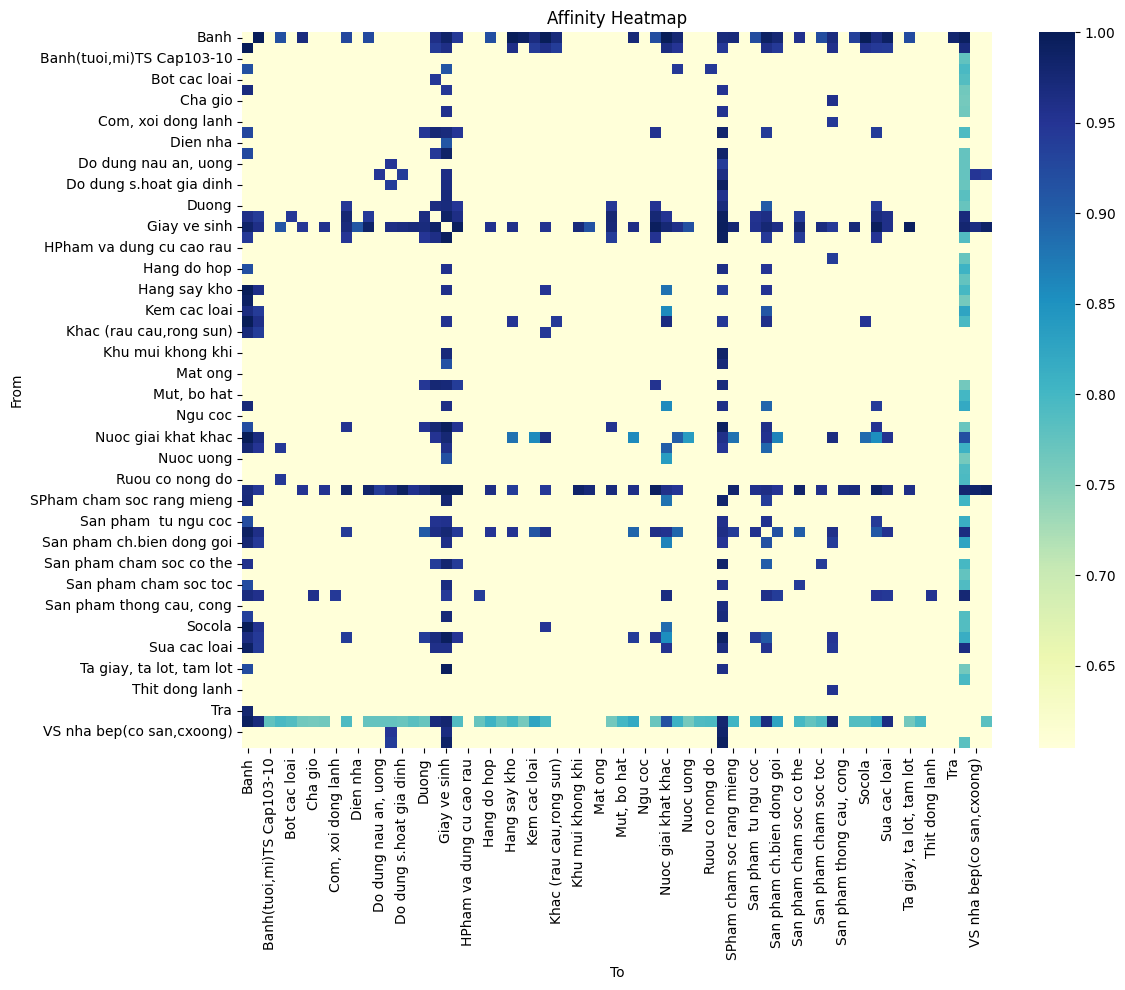

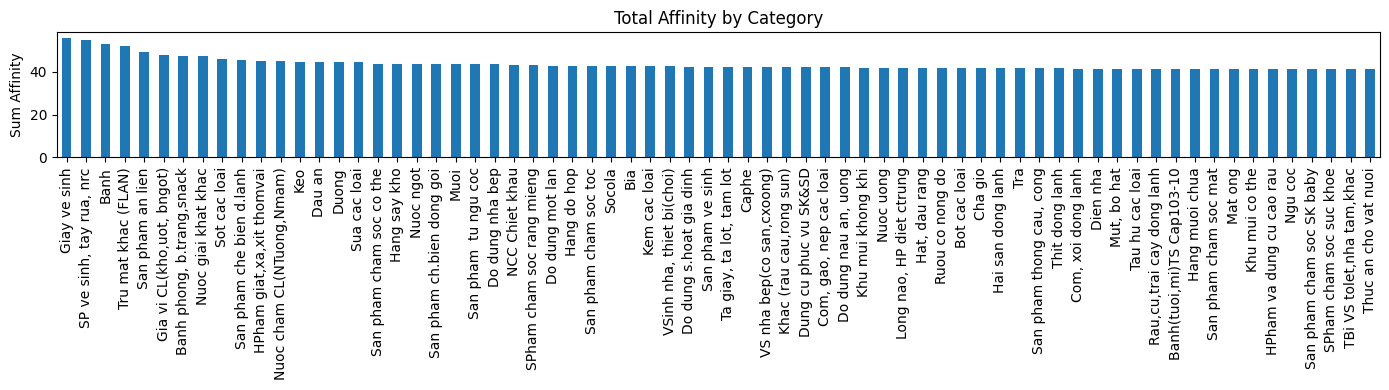

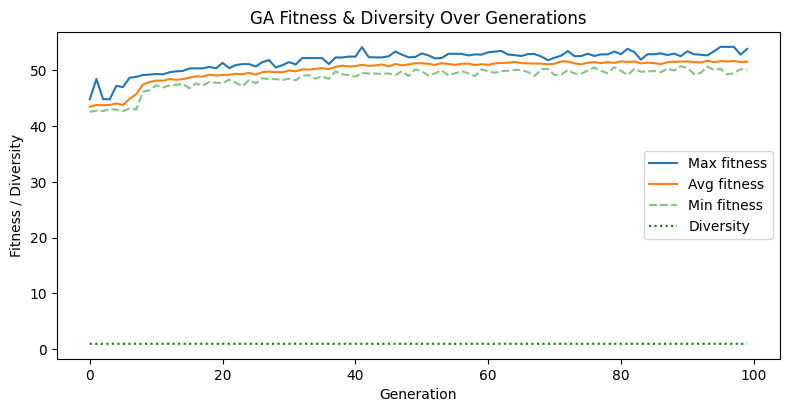

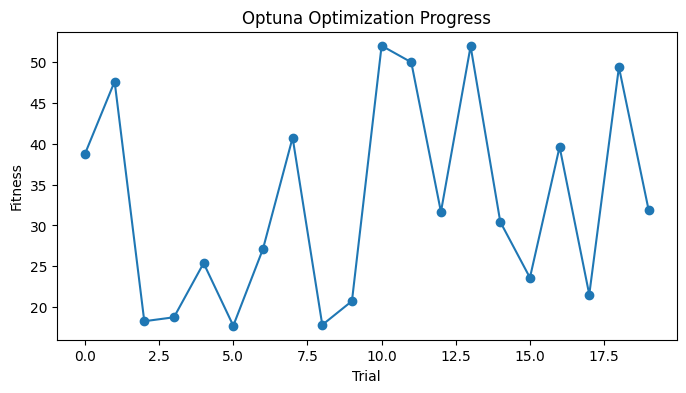

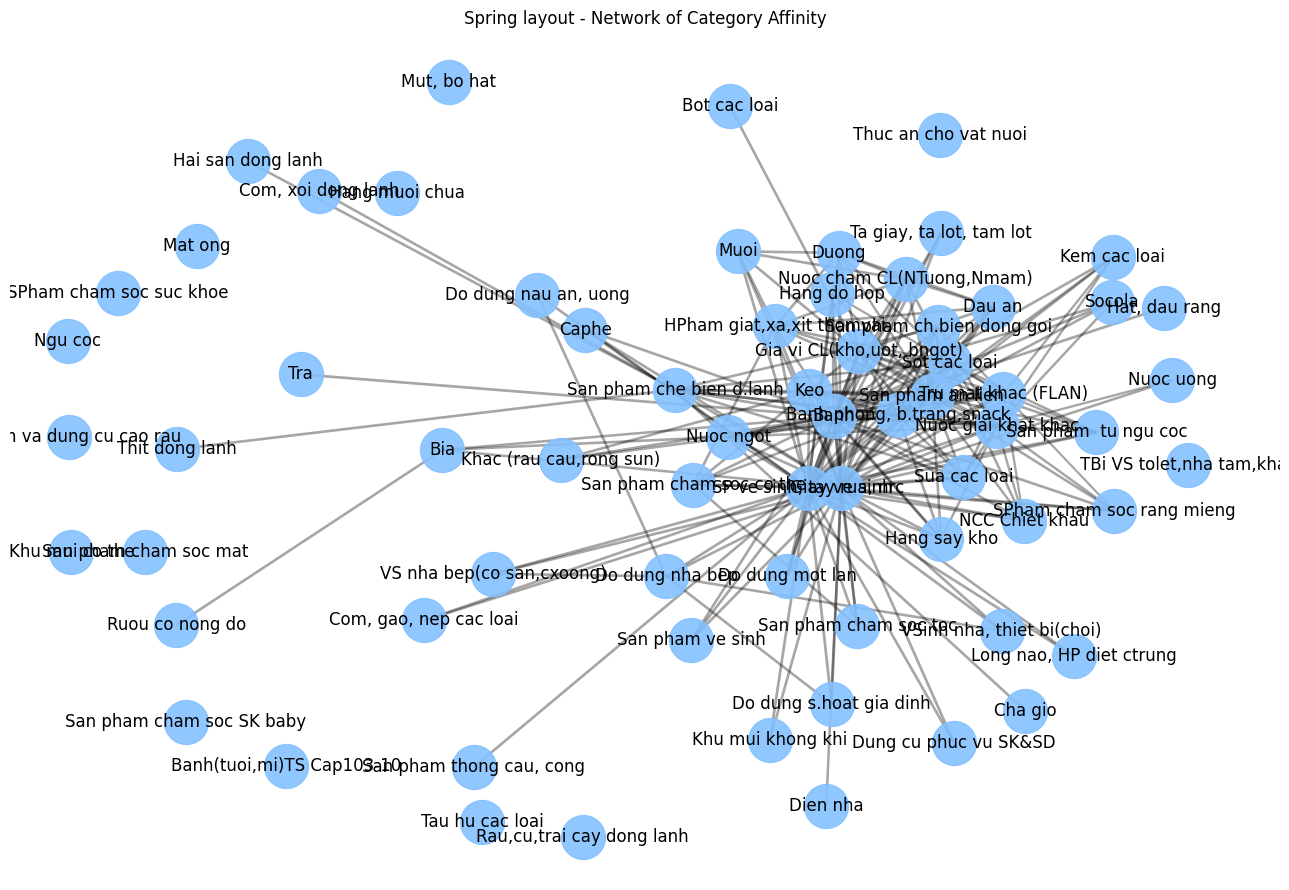

In [ ]:
import ast
import optuna
import pandas as pd
import numpy as np
import random

from src.models.affinity import AffinityBuilder
from src.models.greedy import GreedyLayout
from src.models.cluster_module import ClusterModule
from src.models.forbidden_pairs import get_forbidden_pairs
from src.models.ga_optimizer import GeneticLayoutOptimizer
from src.plots import LayoutVisualizer
from src.config import PROCESSED_DATA_DIR, INTERIM_DATA_DIR


# ----- 1. DATA LOADER -----
class DataLoader:
    def __init__(
        self,
        assoc_rules_path,
        freq_itemsets_path,
        layout_real_path,
        margin_matrix_path=None,
    ):
        self.assoc_rules = pd.read_csv(assoc_rules_path)
        self.freq_itemsets = pd.read_csv(freq_itemsets_path)
        self.layout_real = pd.read_csv(layout_real_path).drop_duplicates(keep="first")
        self.margin_matrix = (
            pd.read_csv(margin_matrix_path, index_col=0)
            if margin_matrix_path is not None
            else None
        )
        self._process()

    def _process(self):
        # Parse items safely
        antecedents = self.assoc_rules["antecedent"].apply(ast.literal_eval)
        consequents = self.assoc_rules["consequent"].apply(ast.literal_eval)
        itemsets = self.freq_itemsets["items"].apply(ast.literal_eval)

        all_items = set()
        for ser in antecedents.tolist() + consequents.tolist():
            all_items.update(ser)
        for sublist in itemsets.tolist():
            all_items.update(sublist)
        self.all_items = sorted(all_items)
        # Real categories & positions
        self.real_categories = set(self.layout_real["Category"].dropna().unique())
        # Use 'Step' as position index (1,2,3...) instead of x/y
        self.positions = list(range(1, len(self.layout_real) + 1))


# ----- 2. HARD RULE ENGINE -----


class HardRuleEngine:
    def __init__(self, rules_dict):
        self.rules = rules_dict or {}

    def check_must_at_entry(self, layout):
        req = self.rules.get("must_at_entry")
        return (not req) or (layout and layout[0] == req[0])

    def check_must_at_exit(self, layout):
        req = self.rules.get("must_at_exit")
        return (not req) or (layout and layout[-1] == req[0])

    def check_must_together(self, layout):
        pairs = self.rules.get("must_together", [])
        return all(
            (
                a in layout
                and b in layout
                and abs(layout.index(a) - layout.index(b)) == 1
            )
            for a, b in pairs
        )

    def check_must_order(self, layout):
        pairs = self.rules.get("must_order", [])
        return all(
            (a in layout and b in layout and layout.index(a) < layout.index(b))
            for a, b in pairs
        )

    def check_all(self, layout):
        return {
            "must_at_entry": self.check_must_at_entry(layout),
            "must_at_exit": self.check_must_at_exit(layout),
            "must_together": self.check_must_together(layout),
            "must_order": self.check_must_order(layout),
        }

    def penalty(self, layout, base_penalty=1e6):
        penalty = 0
        if not self.check_must_at_entry(layout):
            penalty += base_penalty
        if not self.check_must_at_exit(layout):
            penalty += base_penalty
        if not self.check_must_together(layout):
            penalty += base_penalty
        if not self.check_must_order(layout):
            penalty += base_penalty
        return penalty


# ----- 3. OPTUNA RUNNER (tích hợp luôn vào pipeline ở đây, nếu muốn tách riêng thì đơn giản) -----

# ----- 4. PIPELINE -----


class LayoutOptimizationPipeline:
    def __init__(
        self,
        data,
        n_trials=30,
        n_gen_final=80,
        use_optuna=True,
        output_path=None,
        ga_selection="tournament",
        ga_crossover="PMX",
        ga_mutation="shuffle",
        ga_adaptive=True,
        ga_ensemble_runs=1,
        hard_rules=None,
        seed=42,
    ):
        # Seed for reproducibility
        self.seed = seed
        np.random.seed(seed)
        random.seed(seed)
        optuna.seed = seed

        # Data
        self.data = data
        self.n_trials = n_trials
        self.n_gen_final = n_gen_final
        self.use_optuna = use_optuna
        self.output_path = output_path or (
            PROCESSED_DATA_DIR / "layout_real_mapped.csv"
        )
        self.ga_selection = ga_selection
        self.ga_crossover = ga_crossover
        self.ga_mutation = ga_mutation
        self.ga_adaptive = ga_adaptive
        self.ga_ensemble_runs = ga_ensemble_runs
        self.hard_rule_engine = HardRuleEngine(hard_rules)

        # Affinity builder
        self.affinity_builder = AffinityBuilder(
            self.data.assoc_rules,
            self.data.freq_itemsets,
            self.data.all_items,
            self.data.margin_matrix,
        )

        # Positions và Real Categories
        self.positions = self.data.positions
        self.real_categories = self.data.real_categories
        self.all_items = self.data.all_items

    def _get_real_layout_as_seed(self):
        layout_real = self.data.layout_real.sort_values("Step")["Category"].tolist()
        return layout_real

    def _filter_layout(self, best_layout):
        # Filter theo real_categories, kiểm tra độ dài
        filtered = best_layout[: len(self.positions)]
        return filtered

    def objective(self, trial):
        # --- Optuna space ---
        lift_threshold = trial.suggest_float("lift_threshold", 0.0, 2.0)
        penalty = trial.suggest_int("penalty", 10, 150)
        pop_size = trial.suggest_int("pop_size", 100, 500, step=50)
        greedy_ratio = trial.suggest_float("greedy_ratio", 0.05, 0.5)
        w_lift = trial.suggest_float("w_lift", 0.1, 1.0)
        w_conf = trial.suggest_float("w_conf", 0.0, 1.0)
        w_margin = trial.suggest_float("w_margin", 0.0, 1.0)
        gamma = trial.suggest_float("gamma", 0.5, 4.0)
        k = trial.suggest_int("k", 3, 10)
        # Normalize weight
        weight_sum = w_lift + w_conf + w_margin
        w_lift, w_conf, w_margin = (
            w_lift / weight_sum,
            w_conf / weight_sum,
            w_margin / weight_sum,
        )
        # Build affinity matrix
        affinity = self.affinity_builder.build_affinity(
            lift_threshold=lift_threshold,
            w_lift=w_lift,
            w_conf=w_conf,
            w_margin=w_margin,
        )
        affinity = self.affinity_builder.normalize(affinity)
        affinity = self.affinity_builder.kernelize(affinity, gamma=gamma)

        greedy_module = GreedyLayout(self.all_items)
        layout_greedy = greedy_module.init_layout(affinity)
        layout_greedy = greedy_module.local_search(layout_greedy, affinity)

        cluster_module = ClusterModule(self.all_items)
        clustered_items = cluster_module.cluster_categories(affinity, k=k)
        forbidden_pairs = get_forbidden_pairs(affinity, self.all_items)
        layout_real = self._get_real_layout_as_seed()
        ga_module = GeneticLayoutOptimizer(
            self.all_items,
            affinity,
            forbidden_pairs,
            penalty=penalty,
            greedy_ratio=greedy_ratio,
            selection=self.ga_selection,
            crossover=self.ga_crossover,
            mutation=self.ga_mutation,
            adaptive=self.ga_adaptive,
            hard_rules=self.hard_rule_engine.rules,
        )

        if self.ga_ensemble_runs > 1:
            best_run, _ = ga_module.run_ensemble(
                ngen=30,
                pop_size=pop_size,
                greedy_layout=layout_greedy,
                n_runs=self.ga_ensemble_runs,
                init_population_extra=[layout_real],  # Seed layout thực tế!
            )
            best_layout = best_run["best_layout"]
            best_fitness = best_run["best_fitness"]
            logbook = best_run["logbook"]
        else:
            best_layout, best_fitness, logbook = ga_module.run(
                ngen=30,
                pop_size=pop_size,
                greedy_layout=layout_greedy,
                record_logbook=True,
                init_population_extra=[layout_real],  # Seed layout thực tế!
            )  # FILTER layout

        filtered_best_layout = self._filter_layout(best_layout)

        # Penalty nếu vi phạm rule cứng
        total_penalty = self.hard_rule_engine.penalty(filtered_best_layout)
        fitness = best_fitness - total_penalty

        # Save info cho best trial
        trial.set_user_attr("best_layout", filtered_best_layout)
        trial.set_user_attr("logbook", logbook)
        return fitness

    def tune(self):
        study = optuna.create_study(direction="maximize")
        study.optimize(self.objective, n_trials=self.n_trials)
        self.study = study
        self.best_params = study.best_params
        # Save layout/logbook của best trial
        best_trial = study.best_trial
        self.best_layout = best_trial.user_attrs["best_layout"]
        self.best_logbook = best_trial.user_attrs["logbook"]
        print("Best Optuna params:", self.best_params)
        print("Best layout (from Optuna):", self.best_layout)
        return study

    def run_final(self):
        # Dùng best params từ Optuna hoặc tune thủ công
        p = self.best_params
        affinity = self.affinity_builder.build_affinity(
            lift_threshold=p["lift_threshold"],
            w_lift=p["w_lift"],
            w_conf=p["w_conf"],
            w_margin=p["w_margin"],
        )
        affinity = self.affinity_builder.normalize(affinity)
        affinity = self.affinity_builder.kernelize(affinity, gamma=p["gamma"])
        greedy_module = GreedyLayout(self.all_items)
        layout_greedy = greedy_module.init_layout(affinity)
        layout_greedy = greedy_module.local_search(layout_greedy, affinity)
        cluster_module = ClusterModule(self.all_items)
        clustered_items = cluster_module.cluster_categories(affinity, k=p["k"])
        forbidden_pairs = get_forbidden_pairs(affinity, self.all_items)

        layout_real = self._get_real_layout_as_seed()  # Lấy layout thực tế chuẩn hóa

        ga_module = GeneticLayoutOptimizer(
            self.all_items,
            affinity,
            forbidden_pairs,
            penalty=p["penalty"],
            greedy_ratio=p["greedy_ratio"],
            selection=self.ga_selection,
            crossover=self.ga_crossover,
            mutation=self.ga_mutation,
            adaptive=self.ga_adaptive,
            hard_rules=self.hard_rule_engine.rules,
        )

        if self.ga_ensemble_runs > 1:
            best_run, all_results = ga_module.run_ensemble(
                ngen=self.n_gen_final,
                pop_size=p["pop_size"],
                greedy_layout=layout_greedy,
                n_runs=self.ga_ensemble_runs,
                init_population_extra=[layout_real],  # Seed layout thực tế!
            )
            best_layout, best_fitness, logbook = (
                best_run["best_layout"],
                best_run["best_fitness"],
                best_run["logbook"],
            )
            self.all_ensemble_results = all_results
        else:
            best_layout, best_fitness, logbook = ga_module.run(
                ngen=self.n_gen_final,
                pop_size=p["pop_size"],
                greedy_layout=layout_greedy,
                record_logbook=True,
                init_population_extra=[layout_real],  # Seed layout thực tế!
            )

        filtered_best_layout = self._filter_layout(best_layout)

        layout_optimal_xy = pd.DataFrame(
            {
                "Category": filtered_best_layout,
                # "x": [p[0] for p in self.positions[: len(filtered_best_layout)]],
                # "y": [p[1] for p in self.positions[: len(filtered_best_layout)]],
            }
        )
        category2cluster = {cat: idx for idx, cat in enumerate(clustered_items)}
        optional_cluster_list = [
            category2cluster.get(cat, -1) for cat in layout_optimal_xy["Category"]
        ]
        layout_optimal_xy.to_csv(self.output_path, index=False)
        print(f"\nBest layout: {filtered_best_layout}")

        # --- CHECK HARD RULES ---
        print("Hard rule checks:")
        rule_check = self.hard_rule_engine.check_all(filtered_best_layout)
        for k, v in rule_check.items():
            print(f"{k}: {v}")
        total_penalty = self.hard_rule_engine.penalty(filtered_best_layout)
        final_fitness = best_fitness - total_penalty
        print(f"Best fitness: {best_fitness:.4f} (after penalty: {final_fitness:.4f})")

        self.layout_optimal_xy = layout_optimal_xy
        self.affinity = affinity
        self.optional_cluster_list = optional_cluster_list
        self.best_fitness = final_fitness
        self.ga_logbook = pd.DataFrame(logbook)
        return layout_optimal_xy, final_fitness

    def plot_all(self):
        if not hasattr(self, "layout_optimal_xy"):
            print("You must run run_final() before plotting.")
            return
        # LayoutVisualizer.visualize_layout_grid(self.layout_optimal_xy)
        LayoutVisualizer.plot_affinity_heatmap(self.affinity)
        LayoutVisualizer.plot_affinity_bar(self.affinity)
        LayoutVisualizer.plot_ga_convergence(self.ga_logbook)
        if hasattr(self, "study"):
            LayoutVisualizer.plot_optuna_trials(self.study)

        LayoutVisualizer.plot_spring_layout(self.affinity, threshold=0.8)


# ----- Example usage -----
hard_rules = {
    # "must_at_entry": ["Banh"],
    # "must_at_exit": ["Keo"],
    # "must_together": [("Banh", "Keo"), ("Bia", "Nuoc ngot")],
    # "must_order": [("Bia", "Nuoc ngot")],
}

df = DataLoader(
    assoc_rules_path=PROCESSED_DATA_DIR / "association_rules.csv",
    freq_itemsets_path=PROCESSED_DATA_DIR / "frequent_itemsets.csv",
    layout_real_path=INTERIM_DATA_DIR / "layout.csv",
    margin_matrix_path=None,
)
pipeline = LayoutOptimizationPipeline(
    data=df,
    n_trials=20,
    n_gen_final=100,
    ga_selection="tournament",
    ga_crossover="PMX",
    ga_mutation="shuffle",
    ga_adaptive=True,
    ga_ensemble_runs=3,
    hard_rules=hard_rules,
    seed=42,
)

pipeline.tune()
pipeline.run_final()
pipeline.plot_all()

[I 2025-08-12 09:44:52,079] A new study created in memory with name: no-name-c06120b6-9819-41de-85de-06d2a267fef3
c:\Users\lthnhung\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [120, 500] and step=40, but the range is not divisible by `step`. It will be replaced by [120, 480].
  warnings.warn(
[I 2025-08-12 09:44:57,626] Trial 0 finished with value: 13.098823903467213 and parameters: {'lift_threshold': 0.749080237694725, 'w_lift': 0.9556428757689246, 'w_conf': 0.7319939418114051, 'w_margin': 0.5986584841970366, 'gamma': 1.0460652415485279, 'w_aff': 0.7339917805043039, 'w_pair': 0.11616722433639892, 'w_entr': 1.7323522915498704, 'gamma_support': 1.1011150117432087, 'pair_threshold': 0.7832290311184182, 'pop_size': 120, 'elite_ratio': 0.09819459112971966, 'penalty': 129}. Best is trial 0 with value: 13.098823903467213.
c:\Users\lthnhung\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\

Best params: {'lift_threshold': 1.7759806586061957, 'w_lift': 0.7121072043925447, 'w_conf': 0.25289617075667026, 'w_margin': 0.5222729934335286, 'gamma': 2.5440146212323715, 'w_aff': 1.891064274139354, 'w_pair': 0.010729454207001075, 'w_entr': 1.1332012543063168, 'gamma_support': 0.5026679612772813, 'pair_threshold': 0.8596045666365353, 'pop_size': 480, 'elite_ratio': 0.08523992793171244, 'penalty': 21}
Best layout (from Optuna): ['Caphe', 'Sua cac loai', 'San pham cham soc co the', 'HPham giat,xa,xit thomvai', 'Dung cu phuc vu SK&SD', 'SPham cham soc suc khoe', 'Kem cac loai', 'Rau,cu,trai cay dong lanh', 'Hai san dong lanh', 'Cha gio', 'Com, xoi dong lanh', 'San pham che bien d.lanh', 'Tru mat khac (FLAN)', 'Tau hu cac loai', 'Thit dong lanh', 'Com, gao, nep cac loai', 'Giay ve sinh', 'San pham ve sinh', 'SP ve sinh, tay rua, nrc', 'SPham cham soc rang mieng', 'San pham cham soc mat', 'San pham cham soc toc', 'Khu mui co the', 'HPham va dung cu cao rau', 'San pham ch.bien dong goi', 

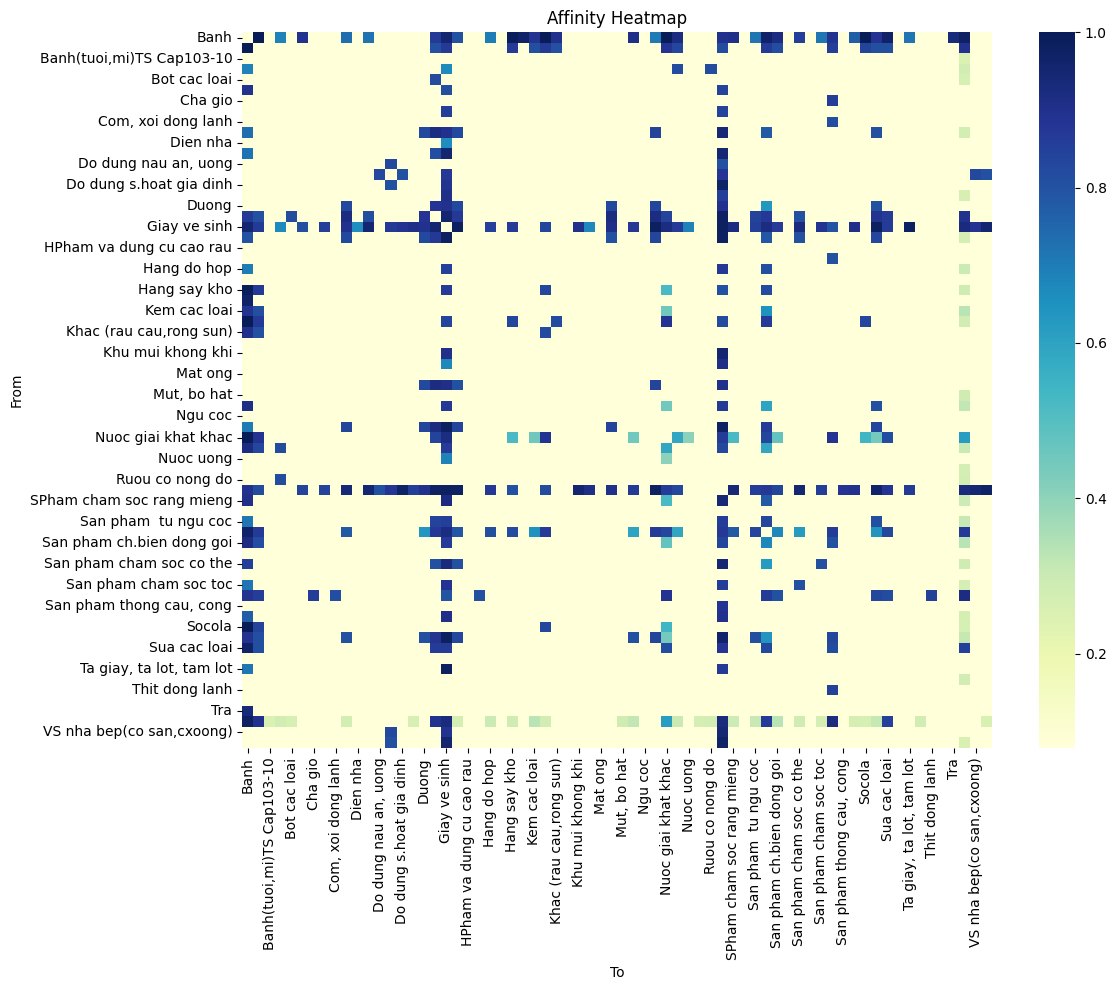

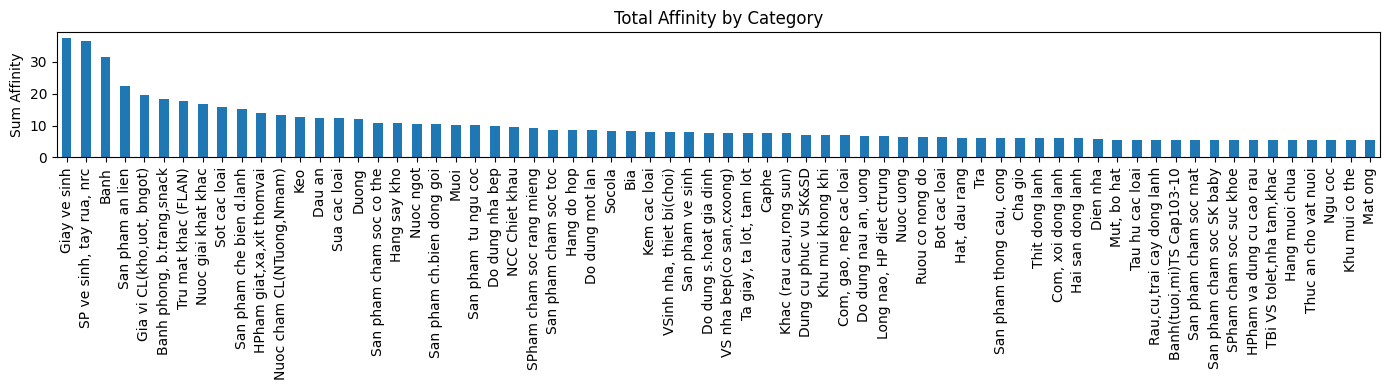

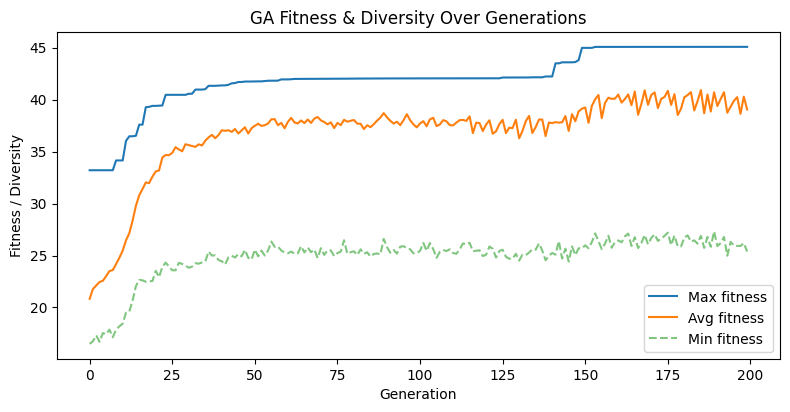

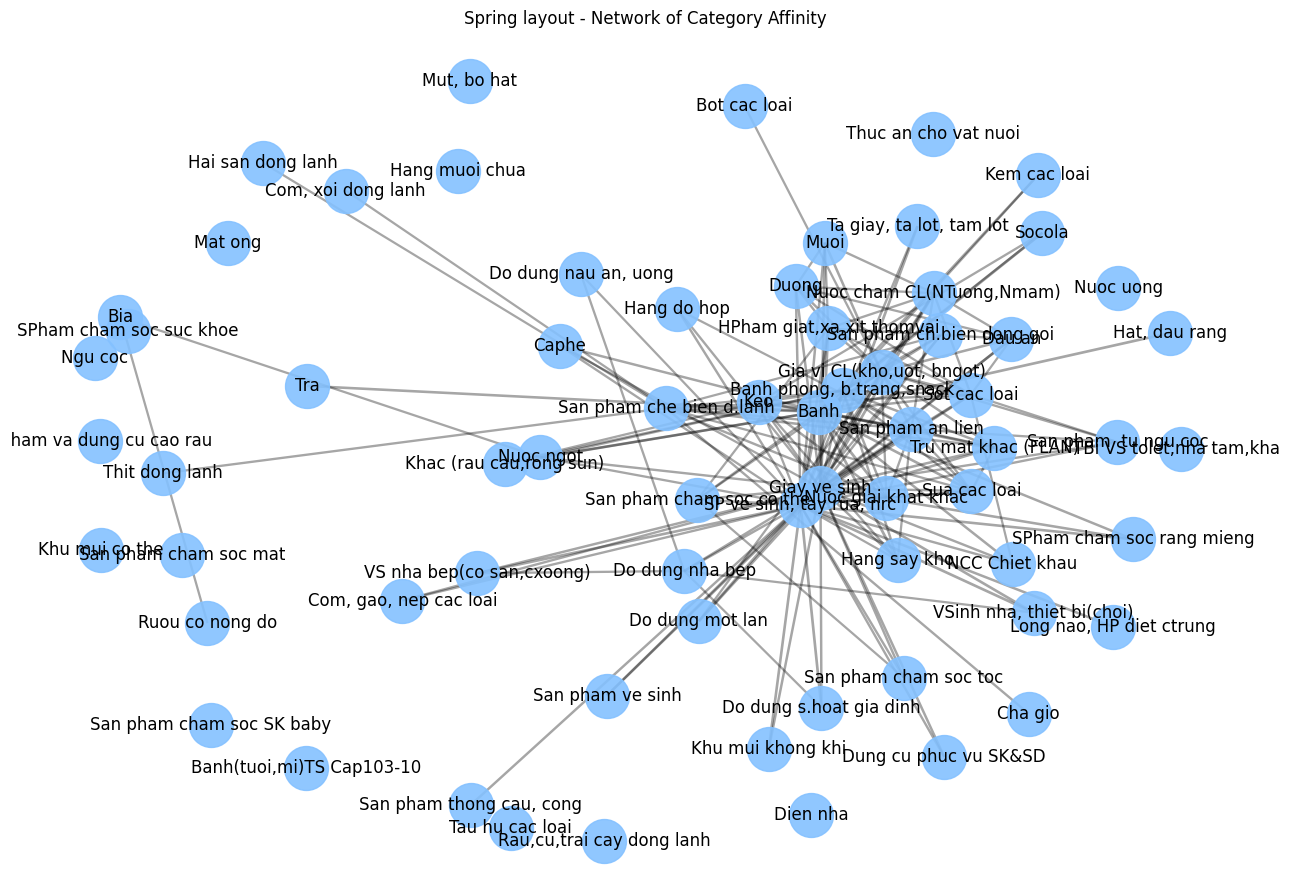

In [3]:
# src/pipelines/pipeline_layout_opt.py
import ast
import random
from typing import Dict, List, Optional, Tuple

import numpy as np
import optuna
import pandas as pd

from src.models.affinity import AffinityBuilder
from src.models.ga_optimizer import GlobalLayoutOptimizer, TwoZoneLayoutOptimizer
from src.models.greedy import GreedyLayout
from src.models.forbidden_pairs import get_forbidden_pairs

from src.plots import LayoutVisualizer
from src.config import PROCESSED_DATA_DIR, INTERIM_DATA_DIR


# =============== Data Loader ===============
class DataLoader:
    def __init__(
        self,
        assoc_rules_path,
        freq_itemsets_path,
        layout_real_path,
        margin_matrix_path: Optional[str] = None,
    ):
        self.assoc_rules = pd.read_csv(assoc_rules_path)
        self.freq_itemsets = pd.read_csv(freq_itemsets_path)
        self.layout_real = pd.read_csv(layout_real_path).drop_duplicates(keep="first")
        self.margin_matrix = (
            pd.read_csv(margin_matrix_path, index_col=0)
            if margin_matrix_path is not None
            else None
        )
        self._process()

    def _process(self):
        antecedents = self.assoc_rules["antecedent"].apply(ast.literal_eval)
        consequents = self.assoc_rules["consequent"].apply(ast.literal_eval)
        itemsets = self.freq_itemsets["items"].apply(ast.literal_eval)

        all_items = set()
        for ser in antecedents.tolist() + consequents.tolist():
            all_items.update(ser)
        for sublist in itemsets.tolist():
            all_items.update(sublist)

        layout_cats = self.layout_real["Category"].dropna().astype(str).tolist()
        all_items.update(layout_cats)
        self.all_items: List[str] = sorted(all_items)

        if {"x", "y"}.issubset(self.layout_real.columns):
            self.positions = list(zip(self.layout_real["x"], self.layout_real["y"]))
        else:
            raise ValueError("layout_real.csv thiếu cột x,y")

        # fill defaults
        for col in ["is_refrigerated", "is_entrance", "is_cashier", "width", "height"]:
            if col not in self.layout_real.columns:
                self.layout_real[col] = 0

        self.refrig_cats = (
            self.layout_real.loc[self.layout_real["is_refrigerated"] == 1, "Category"]
            .astype(str)
            .tolist()
        )

    # helpers
    def sorted_slots_xy(self) -> pd.DataFrame:
        df = self.layout_real.sort_values(["y", "x"]).reset_index(drop=True)
        if "width" not in df.columns:
            df["width"] = 0
        if "height" not in df.columns:
            df["height"] = 0
        return df[["Category", "x", "y", "width", "height"]].copy()


# =============== Pipeline ===============
class LayoutOptimizationPipeline:
    def __init__(
        self,
        data: DataLoader,
        n_trials: int = 30,
        n_gen_final: int = 80,
        use_optuna: bool = True,
        output_path: Optional[str] = None,
        selection: str = "tournament",
        crossover: str = "PMX",
        mutation: str = "shuffle",
        adaptive: bool = True,
        seed: int = 42,
    ):
        self.data = data
        self.n_trials = n_trials
        self.n_gen_final = n_gen_final
        self.use_optuna = use_optuna
        self.output_path = output_path or (
            PROCESSED_DATA_DIR / "layout_real_mapped.csv"
        )
        self.selection, self.crossover, self.mutation = selection, crossover, mutation
        self.adaptive = adaptive
        self.seed = seed
        np.random.seed(seed)
        random.seed(seed)

        self.all_items = data.all_items
        self.refrig_cats = data.refrig_cats

        self.affinity_builder = AffinityBuilder(
            self.data.assoc_rules,
            self.data.freq_itemsets,
            self.data.all_items,
            self.data.margin_matrix,
        )

        # holders
        self.ga_logbook: Optional[pd.DataFrame] = None
        self.best_logbook: Optional[pd.DataFrame] = None

    # ---- helpers ----
    def _coords_and_entrance(
        self, override_entr_xy: Optional[Tuple[float, float]] = None
    ):
        slots = self.data.sorted_slots_xy()
        coords = list(
            zip(slots["x"] + slots["width"] * 0.5, slots["y"] + slots["height"] * 0.5)
        )
        if override_entr_xy is not None:
            return coords, tuple(override_entr_xy)

        df = self.data.layout_real
        if (
            "is_entrance" in df.columns
            and df["is_entrance"].fillna(0).astype(int).any()
        ):
            row = (
                df.loc[df["is_entrance"].fillna(0).astype(int) == 1]
                .sort_values(["y", "x"])
                .iloc[0]
            )
            ex = float(row["x"]) + float(row.get("width", 0)) * 0.5
            ey = float(row["y"]) + float(row.get("height", 0)) * 0.5
            return coords, (ex, ey)

        name_col = df["Category"].astype(str).str.lower()
        hits = name_col.isin({"entrance", "entry", "door", "cửa vào", "lối vào"})
        if hits.any():
            row = df.loc[hits].sort_values(["y", "x"]).iloc[0]
            ex = float(row["x"]) + float(row.get("width", 0)) * 0.5
            ey = float(row["y"]) + float(row.get("height", 0)) * 0.5
            return coords, (ex, ey)

        row = df.sort_values(["y", "x"]).iloc[0]
        ex = float(row["x"]) + float(row.get("width", 0)) * 0.5
        ey = float(row["y"]) + float(row.get("height", 0)) * 0.5
        return coords, (ex, ey)

    def _cat_support(self) -> Dict[str, float]:
        cs = {c: 0.0 for c in self.all_items}
        df = self.data.freq_itemsets
        if "items" in df.columns and "support" in df.columns:
            for _, r in df.iterrows():
                try:
                    items = ast.literal_eval(r["items"])
                except Exception:
                    continue
                sup = float(r["support"])
                for it in items:
                    if it in cs:
                        cs[it] = max(cs[it], sup)
        return cs

    def _pairs_list(self, affinity: pd.DataFrame, threshold: float):
        pairs = []
        for a in self.all_items:
            for b in self.all_items:
                if a >= b:
                    continue
                w = float(affinity.loc[a, b])
                if w >= threshold:
                    pairs.append((a, b, w))
        return pairs

    def _seed_layout_real(self) -> List[str]:
        known = set(self.all_items)
        return (
            self.data.sorted_slots_xy()["Category"]
            .astype(str)
            .apply(lambda x: x if x in known else None)
            .dropna()
            .tolist()
        )

    def _filter_to_slot_len(self, layout: List[str]) -> List[str]:
        return layout[: len(self.data.positions)]

    # ---- Optuna objective ----
    def _objective(self, trial: optuna.trial.Trial) -> float:
        # Affinity params
        lift_threshold = trial.suggest_float("lift_threshold", 0.0, 2.0)
        w_lift = trial.suggest_float("w_lift", 0.1, 1.0)
        w_conf = trial.suggest_float("w_conf", 0.0, 1.0)
        w_margin = trial.suggest_float("w_margin", 0.0, 1.0)
        gamma = trial.suggest_float("gamma", 0.5, 4.0)

        # Mixed fitness
        w_aff = trial.suggest_float("w_aff", 0.5, 2.0)
        w_pair = trial.suggest_float("w_pair", 0.0, 2.0)
        w_entr = trial.suggest_float("w_entr", 0.0, 2.0)
        gamma_support = trial.suggest_float("gamma_support", 0.5, 1.5)
        pair_threshold = trial.suggest_float("pair_threshold", 0.5, 0.9)

        # GA params
        pop_size = trial.suggest_int("pop_size", 120, 500, step=40)
        elite_ratio = trial.suggest_float("elite_ratio", 0.04, 0.1)
        penalty = trial.suggest_int("penalty", 20, 150)

        # normalize weights
        s = w_lift + w_conf + w_margin
        w_lift, w_conf, w_margin = w_lift / s, w_conf / s, w_margin / s

        # Build affinity
        affinity = self.affinity_builder.build_affinity(
            lift_threshold=lift_threshold,
            w_lift=w_lift,
            w_conf=w_conf,
            w_margin=w_margin,
        )
        affinity = self.affinity_builder.normalize(affinity)
        affinity = self.affinity_builder.kernelize(affinity, gamma=gamma)

        # Seeds & inputs
        greedy = GreedyLayout(self.all_items)
        layout_greedy = greedy.local_search(greedy.init_layout(affinity), affinity)
        coords, entr_xy = self._coords_and_entrance()
        cat_support = self._cat_support()
        pairs_list = self._pairs_list(affinity, threshold=pair_threshold)
        forbidden_pairs = get_forbidden_pairs(affinity, self.all_items)
        baseline = self._seed_layout_real()

        # Choose engine
        if len(self.refrig_cats) > 0:
            ga = TwoZoneLayoutOptimizer(
                all_items=self.all_items,
                refrig_cats=self.refrig_cats,
                affinity_matrix=affinity,
                forbidden_pairs=forbidden_pairs,
                penalty_forbidden=penalty,
                hard_rules={},
                coords=coords,
                entr_xy=entr_xy,
                cat_support=cat_support,
                pairs_list=pairs_list,
                w_aff=w_aff,
                w_pair=w_pair,
                w_entr=w_entr,
                gamma_support=gamma_support,
                selection=self.selection,
                crossover=self.crossover,
                mutation=self.mutation,
                anchor_start=None,
            )
            best_layout, best_fitness, logbook = ga.run(
                ngen=30,
                pop_size=pop_size,
                seed=self.seed,
                elite_ratio=elite_ratio,
                adaptive=self.adaptive,
                return_all=False,
                baseline=baseline or layout_greedy,
                # lưu log thử nghiệm vào trial
                log_csv_path=None,
                as_dataframe=True,
            )
        else:
            ga = GlobalLayoutOptimizer(
                all_items=self.all_items,
                affinity_matrix=affinity,
                forbidden_pairs=forbidden_pairs,
                penalty_forbidden=penalty,
                hard_rules={},
                coords=coords,
                entr_xy=entr_xy,
                cat_support=cat_support,
                pairs_list=pairs_list,
                w_aff=w_aff,
                w_pair=w_pair,
                w_entr=w_entr,
                gamma_support=gamma_support,
                selection=self.selection,
                crossover=self.crossover,
                mutation=self.mutation,
            )
            best_layout, best_fitness, logbook = ga.run(
                ngen=30,
                pop_size=pop_size,
                seed=self.seed,
                elite_ratio=elite_ratio,
                adaptive=self.adaptive,
                return_all=False,
                baseline=baseline or layout_greedy,
                log_csv_path=None,
                as_dataframe=True,
            )

        # gắn logbook vào trial để xem lại
        try:
            log_df = getattr(ga, "logbook_df", None)
            if log_df is not None:
                trial.set_user_attr("logbook", log_df.to_dict("records"))
            else:
                trial.set_user_attr("logbook", logbook)
        except Exception:
            pass

        trial.set_user_attr("best_layout", self._filter_to_slot_len(best_layout))
        return float(best_fitness)

    # ---- Public API ----
    def tune(self):
        sampler = optuna.samplers.TPESampler(seed=self.seed)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(self._objective, n_trials=self.n_trials)
        self.study = study
        self.best_params = study.best_params
        self.best_layout = study.best_trial.user_attrs["best_layout"]
        # lưu logbook của best trial (nếu có)
        try:
            self.best_logbook = pd.DataFrame(
                study.best_trial.user_attrs.get("logbook", [])
            )
        except Exception:
            self.best_logbook = None

        print("Best params:", self.best_params)
        print("Best layout (from Optuna):", self.best_layout)
        return study

    def run_final(self):
        if not hasattr(self, "best_params"):
            raise RuntimeError("Hãy gọi tune() trước.")

        p = self.best_params
        affinity = self.affinity_builder.build_affinity(
            lift_threshold=p["lift_threshold"],
            w_lift=p["w_lift"],
            w_conf=p["w_conf"],
            w_margin=p["w_margin"],
        )
        affinity = self.affinity_builder.normalize(affinity)
        affinity = self.affinity_builder.kernelize(affinity, gamma=p["gamma"])

        coords, entr_xy = self._coords_and_entrance()
        cat_support = self._cat_support()
        pairs_list = self._pairs_list(affinity, threshold=p["pair_threshold"])
        forbidden_pairs = get_forbidden_pairs(affinity, self.all_items)
        baseline = self._seed_layout_real()

        # chọn engine
        if len(self.refrig_cats) > 0:
            ga = TwoZoneLayoutOptimizer(
                all_items=self.all_items,
                refrig_cats=self.refrig_cats,
                affinity_matrix=affinity,
                forbidden_pairs=forbidden_pairs,
                penalty_forbidden=p["penalty"],
                hard_rules={},
                coords=coords,
                entr_xy=entr_xy,
                cat_support=cat_support,
                pairs_list=pairs_list,
                w_aff=p["w_aff"],
                w_pair=p["w_pair"],
                w_entr=p["w_entr"],
                gamma_support=p["gamma_support"],
                selection=self.selection,
                crossover=self.crossover,
                mutation=self.mutation,
            )
        else:
            ga = GlobalLayoutOptimizer(
                all_items=self.all_items,
                affinity_matrix=affinity,
                forbidden_pairs=forbidden_pairs,
                penalty_forbidden=p["penalty"],
                hard_rules={},
                coords=coords,
                entr_xy=entr_xy,
                cat_support=cat_support,
                pairs_list=pairs_list,
                w_aff=p["w_aff"],
                w_pair=p["w_pair"],
                w_entr=p["w_entr"],
                gamma_support=p["gamma_support"],
                selection=self.selection,
                crossover=self.crossover,
                mutation=self.mutation,
            )

        # lưu logbook final ra CSV
        log_csv = PROCESSED_DATA_DIR / "ga_logbook_final.csv"

        best_layout, best_fitness, logbook = ga.run(
            ngen=self.n_gen_final,
            pop_size=p["pop_size"],
            seed=self.seed,
            elite_ratio=p["elite_ratio"],
            adaptive=self.adaptive,
            return_all=False,
            baseline=baseline,
            log_csv_path=str(log_csv),
            as_dataframe=True,
        )

        # lưu logbook để vẽ
        self.ga_logbook = getattr(ga, "logbook_df", None)
        if self.ga_logbook is None:
            try:
                self.ga_logbook = pd.DataFrame(logbook)
            except Exception:
                self.ga_logbook = None

        # Xuất file theo slot (y,x)
        best_layout = [str(c) for c in self._filter_to_slot_len(best_layout)]
        slots = self.data.sorted_slots_xy()
        n = min(len(best_layout), len(slots))
        layout_opt = pd.DataFrame(
            {
                "Category": best_layout[:n],
                "x": slots.loc[: n - 1, "x"].to_list(),
                "y": slots.loc[: n - 1, "y"].to_list(),
                "width": slots.loc[: n - 1, "width"].to_list(),
                "height": slots.loc[: n - 1, "height"].to_list(),
            }
        )
        layout_opt["cx"] = layout_opt["x"] + layout_opt["width"] / 2.0
        layout_opt["cy"] = layout_opt["y"] + layout_opt["height"] / 2.0

        layout_opt.to_csv(self.output_path, index=False)
        self.affinity = affinity
        self.layout_opt = layout_opt
        self.best_fitness = best_fitness

        print("\nBest layout:", best_layout)
        print(f"Best fitness: {best_fitness:.4f}")
        return layout_opt, best_fitness

    def plot_all(self):
        if not hasattr(self, "layout_opt"):
            print("Hãy chạy run_final() trước khi plot.")
            return
        LayoutVisualizer.plot_affinity_heatmap(self.affinity)
        LayoutVisualizer.plot_affinity_bar(self.affinity)
        # Ưu tiên logbook final; nếu không có thì dùng best_logbook từ tune()
        log_df = self.ga_logbook if self.ga_logbook is not None else self.best_logbook
        if log_df is not None and not log_df.empty:
            LayoutVisualizer.plot_ga_convergence(log_df)
        LayoutVisualizer.plot_spring_layout(self.affinity, threshold=0.8)


# =============== Example usage ===============
if __name__ == "__main__":
    df = DataLoader(
        assoc_rules_path=PROCESSED_DATA_DIR / "association_rules.csv",
        freq_itemsets_path=PROCESSED_DATA_DIR / "frequent_itemsets.csv",
        layout_real_path=INTERIM_DATA_DIR / "layout.csv",
        margin_matrix_path=None,
    )

    pipeline = LayoutOptimizationPipeline(
        data=df,
        n_trials=30,
        n_gen_final=200,
        selection="tournament",
        crossover="PMX",
        mutation="shuffle",
        adaptive=True,
        seed=42,
    )

    pipeline.tune()
    pipeline.run_final()
    pipeline.plot_all()

In [8]:
pipeline.ga_logbook

In [6]:
# src/plots_ga.py

import math
import random
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

PADDING_RATIO = 0.06


# ========= Distance helpers =========
def manhattan(p: Tuple[float, float], q: Tuple[float, float]) -> float:
    return abs(p[0] - q[0]) + abs(p[1] - q[1])


def greedy_path_length(
    points: List[Tuple[float, float]],
    start: Tuple[float, float],
    end: Tuple[float, float],
    dist_fn=manhattan,
) -> float:
    if not points:
        return dist_fn(start, end)
    unvisited = points[:]
    cur = start
    total = 0.0
    while unvisited:
        i_min = min(range(len(unvisited)), key=lambda i: dist_fn(cur, unvisited[i]))
        nxt = unvisited.pop(i_min)
        total += dist_fn(cur, nxt)
        cur = nxt
    total += dist_fn(cur, end)
    return total


# ========= Rasterize & Visual =========
def estimate_cell_size_from_layout(df: pd.DataFrame) -> float:
    vals = []
    arr = df[["x", "y", "width", "height"]].values
    n = len(arr)
    for i in range(n):
        x0, y0, w0, h0 = arr[i]
        x0b, y0b = x0 + w0, y0 + h0
        for j in range(i + 1, n):
            x1, y1, w1, h1 = arr[j]
            x1b, y1b = x1 + w1, y1 + h1
            if not (y0b < y1 or y1b < y0):
                gx = max(0, x0 - x1b, x1 - x0b)
                if gx > 1:
                    vals.append(gx)
            if not (x0b < x1 or x1b < x0):
                gy = max(0, y0 - y1b, y1 - y0b)
                if gy > 1:
                    vals.append(gy)
    if vals:
        return max(1, int(min(vals)) // 2)
    min_dim = np.minimum(df["width"], df["height"])
    return (
        max(1, int(np.median(min_dim[min_dim > 0]) / 4)) if (min_dim > 0).any() else 5
    )


def rasterize_grid(df: pd.DataFrame, cell_size: float):
    cats = list(df["Category"].astype(str).unique())
    name2id = {c: i + 1 for i, c in enumerate(cats)}
    id2name = {v: k for k, v in name2id.items()}

    x0, y0 = df["x"].min(), df["y"].min()
    x1, y1 = (df["x"] + df["width"]).max(), (df["y"] + df["height"]).max()
    pad_x, pad_y = int((x1 - x0) * PADDING_RATIO), int((y1 - y0) * PADDING_RATIO)
    min_x, min_y = x0 - pad_x, y0 - pad_y
    max_x, max_y = x1 + pad_x, y1 + pad_y

    W = int(math.ceil((max_x - min_x) / cell_size))
    H = int(math.ceil((max_y - min_y) / cell_size))
    if W * H > 1e7:  # memory guard
        scale_factor = math.sqrt((W * H) / 1e7)
        cell_size *= scale_factor
        W = int(math.ceil((max_x - min_x) / cell_size))
        H = int(math.ceil((max_y - min_y) / cell_size))

    grid = np.zeros((H, W), dtype=np.int32)
    for _, r in df.iterrows():
        did = name2id[str(r["Category"])]
        gx0 = int(math.floor((r["x"] - min_x) / cell_size))
        gx1 = int(math.ceil((r["x"] + r["width"] - min_x) / cell_size))
        gy0 = int(math.floor((r["y"] - min_y) / cell_size))
        gy1 = int(math.ceil((r["y"] + r["height"] - min_y) / cell_size))
        grid[gy0:gy1, gx0:gx1] = did

    meta = {"min_x": min_x, "min_y": min_y, "cell_size": cell_size, "W": W, "H": H}
    return grid, name2id, id2name, meta


def _draw_grid(grid: np.ndarray, id2name: Dict[int, str], title: str, out_png: Path):
    H, W = grid.shape
    unique_ids = np.unique(grid)
    max_id = int(unique_ids.max()) if len(unique_ids) > 0 else 0

    colors = ["#F9F9F9"] + [
        plt.cm.get_cmap("tab20", max(1, max_id))(i) for i in range(max_id)
    ]
    cmap = mcolors.ListedColormap(colors)
    bounds = list(range(0, max_id + 2))
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig_w = min(30, 18 * (W / max(1, H)))
    fig_h = min(30, 18)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.imshow(grid, cmap=cmap, norm=norm, interpolation="none")

    for did in np.unique(grid[grid > 0]):
        ys, xs = np.where(grid == did)
        if len(xs) == 0:
            continue
        cx, cy = np.mean(xs), np.mean(ys)
        name = id2name.get(did, f"ID {did}")
        region_color = cmap(norm(did))
        lum = (
            0.299 * region_color[0] + 0.587 * region_color[1] + 0.114 * region_color[2]
        )
        w = xs.max() - xs.min() + 1
        h = ys.max() - ys.min() + 1
        rot = 90 if h > w * 1.6 and len(name) > 5 else 0
        ax.text(
            cx,
            cy,
            name,
            va="center",
            ha="center",
            color="black",
            fontsize=4,
            rotation=rot,
        )

    ax.set_title(title, fontsize=5)
    ax.grid(False)
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )
    plt.savefig(out_png, dpi=220, bbox_inches="tight")
    plt.close(fig)


def visualize_ga_layout(df_layout: pd.DataFrame, out_png: Path) -> None:
    """
    Vẽ preview layout của GA giống phong cách SA (grid + label).
    df_layout yêu cầu có cột: Category, x, y, width, height
    """
    cell = estimate_cell_size_from_layout(df_layout)
    grid, name2id, id2name, meta = rasterize_grid(df_layout, cell)
    _draw_grid(grid, id2name, "Layout tối ưu từ GA (grid preview)", out_png)


def visualize_compare_layouts(
    df_before: pd.DataFrame,
    df_after: pd.DataFrame,
    out_png: Path,
    titles: Tuple[str, str] = ("Trước GA", "Sau GA"),
) -> None:
    """
    Vẽ 2 layout (trước/sau) cạnh nhau để so sánh.
    """
    cell_a = estimate_cell_size_from_layout(df_before)
    grid_a, _, id2name_a, _ = rasterize_grid(df_before, cell_a)

    cell_b = estimate_cell_size_from_layout(df_after)
    grid_b, _, id2name_b, _ = rasterize_grid(df_after, cell_b)

    H1, W1 = grid_a.shape
    H2, W2 = grid_b.shape

    max_id_a = int(np.unique(grid_a).max()) if grid_a.size else 0
    max_id_b = int(np.unique(grid_b).max()) if grid_b.size else 0
    max_id = max(max_id_a, max_id_b)

    colors = ["#F9F9F9"] + [
        plt.cm.get_cmap("tab20", max(1, max_id))(i) for i in range(max_id)
    ]
    cmap = mcolors.ListedColormap(colors)
    bounds = list(range(0, max_id + 2))
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig_w = min(30, 18 * ((W1 + W2) / max(1, max(H1, H2))))
    fig_h = min(30, 18)
    fig, axs = plt.subplots(1, 2, figsize=(fig_w, fig_h))

    # left
    axs[0].imshow(grid_a, cmap=cmap, norm=norm, interpolation="none")
    axs[0].set_title(
        titles[0],
        fontsize=5,
    )
    axs[0].grid(False)
    axs[0].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    # right
    axs[1].imshow(grid_b, cmap=cmap, norm=norm, interpolation="none")
    axs[1].set_title(
        titles[1],
        fontsize=5,
    )
    axs[1].grid(False)
    axs[1].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.savefig(out_png, dpi=220, bbox_inches="tight")
    plt.close(fig)


# ========= Benchmark path =========
def benchmark_path_length(
    df_before: pd.DataFrame,
    df_after: pd.DataFrame,
    baskets: List[List[str]],
    entr_xy: Tuple[float, float],
    cash_xy: Tuple[float, float],
    sample_size: int = 500,
    random_state: Optional[int] = 42,
) -> Dict[str, float]:
    """
    So sánh độ dài đường đi greedy (Manhattan) trước/sau GA.
    df_* cần có cột: Category, cx, cy, is_entrance, is_cashier
    """
    if random_state is not None:
        random.seed(random_state)

    def cat2xy(df):
        return {
            str(r["Category"]): (r["cx"], r["cy"])
            for _, r in df.iterrows()
            if not (r.get("is_entrance", False) or r.get("is_cashier", False))
        }

    before_map = cat2xy(df_before)
    after_map = cat2xy(df_after)

    if baskets and len(baskets) > sample_size:
        sample_b = random.sample(baskets, sample_size)
    else:
        sample_b = baskets or []

    def avg_len(mapping):
        if not sample_b:
            return float("nan")
        lens = []
        for b in sample_b:
            pts = [mapping[c] for c in b if c in mapping]
            L = greedy_path_length(pts, entr_xy, cash_xy, manhattan)
            lens.append(L)
        return float(np.mean(lens)) if lens else float("nan")

    base_L = avg_len(before_map)
    new_L = avg_len(after_map)
    improve = (
        (base_L - new_L) / base_L * 100
        if (base_L and base_L > 0 and not math.isnan(base_L))
        else float("nan")
    )
    return {"base_length": base_L, "new_length": new_L, "improvement_pct": improve}


df_before = pipeline.data.layout_real.copy()

# Nếu thiếu width/height thì merge theo (x,y)
if not {"width", "height"}.issubset(pipeline.layout_opt.columns):
    geom = df_before[["x", "y", "width", "height"]].drop_duplicates()
    pipeline.layout_opt = pipeline.layout_opt.merge(geom, on=["x", "y"], how="left")
    # fallback nếu vẫn còn NaN
    if pipeline.layout_opt["width"].isna().any():
        mw = geom["width"].median()
        mh = geom["height"].median()
        pipeline.layout_opt["width"] = pipeline.layout_opt["width"].fillna(mw)
        pipeline.layout_opt["height"] = pipeline.layout_opt["height"].fillna(mh)

# Thêm cx, cy nếu cần
if "cx" not in pipeline.layout_opt.columns or "cy" not in pipeline.layout_opt.columns:
    pipeline.layout_opt["cx"] = (
        pipeline.layout_opt["x"] + pipeline.layout_opt["width"] / 2
    )
    pipeline.layout_opt["cy"] = (
        pipeline.layout_opt["y"] + pipeline.layout_opt["height"] / 2
    )

from src.config import OUTPUT_DATA_DIR

# 1) Vẽ PNG layout tối ưu
png_out = OUTPUT_DATA_DIR / "ga_layout_preview.png"
visualize_ga_layout(pipeline.layout_opt, png_out)

# 2) (Tuỳ chọn) So sánh trước/sau nếu có df_before (layout gốc đã chuẩn hoá cột)
# self.data.layout_real cần có width,height,cx,cy,is_entrance,is_cashier
# nếu thiếu cx,cy: bạn có thể set cx=x+width/2, cy=y+height/2 trước khi gọi
df_before = pipeline.data.layout_real.copy()
if "cx" not in df_before.columns or "cy" not in df_before.columns:
    df_before["cx"] = df_before["x"] + df_before["width"] / 2
    df_before["cy"] = df_before["y"] + df_before["height"] / 2
if "cx" not in pipeline.layout_opt.columns or "cy" not in pipeline.layout_opt.columns:
    pipeline.layout_opt["cx"] = (
        pipeline.layout_opt["x"] + pipeline.layout_opt["y"] * 0
    )  # tránh lỗi
    # tốt nhất dùng width/height thực; nếu có, set:
    # self.layout_optimal_xy["cx"] = self.layout_optimal_xy["x"] + self.layout_optimal_xy["width"]/2
    # self.layout_optimal_xy["cy"] = self.layout_optimal_xy["y"] + self.layout_optimal_xy["height"]/2

png_compare = OUTPUT_DATA_DIR / "ga_layout_compare.png"
visualize_compare_layouts(df_before, pipeline.layout_opt, png_compare)

# 3) Benchmark chiều dài đường đi (nếu bạn có baskets, entr_xy, cash_xy)
# giả sử bạn đã có 3 biến này ở đâu đó trong pipeline hoặc truyền vào
# result = benchmark_path_length(
#     df_before,
#     pipeline.layout_opt,
# )
# print(result)

C:\Users\lthnhung\AppData\Local\Temp\ipykernel_21244\4188025389.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap("tab20", max(1, max_id))(i) for i in range(max_id)
C:\Users\lthnhung\AppData\Local\Temp\ipykernel_21244\4188025389.py:188: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap("tab20", max(1, max_id))(i) for i in range(max_id)


C:\Users\lthnhung\AppData\Local\Temp\ipykernel_83908\671398867.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap("tab20", max(1, max_id))(i) for i in range(max_id)
C:\Users\lthnhung\AppData\Local\Temp\ipykernel_83908\671398867.py:190: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.cm.get_cmap("tab20", max(1, max_id))(i) for i in range(max_id)
